In [1]:


!pip install -q --upgrade ipykernel==5.5.6
!pip install -q --upgrade ipython==7.34.0
!pip install scikit-surprise
!pip install wget
!pip install progressbar
!pip install opendatasets --upgrade
!pip install mlflow
!pip install pyngrok
!pip install pyyaml
!pip install keras
!pip install uvicorn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp310-cp310-linux_x86_64.whl size=3163739 sha256=ff01a5b7d158ae3fac29a8a0db8d15975460723b9eb2afbd28a9acaba80c5ae0
  Stored in directory: /root/.cache/pip/wheels/a5/ca/a8/4e28def53797fdc4363ca4af740db15a9c2f1595ebc51fb445
Successfully built scikit-surprise
  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9655 sha256=71b751c75918029608c22c74e44f94325beb88ca47f7cecdbc615791401e14cf
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget
  Preparing metadata (setup.py) ... done
  Created wheel for progressbar: filename=progressbar-2.5-py3-none-any.whl size=12067 sha256=135e4c997c00bbdea4a812e905134396e6378b003b7c2c06ef579f5ea07bc058
  Stored in directory: /root/.cache/pip

In [2]:
import wget
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import progressbar
from surprise import Reader, Dataset
from surprise.model_selection import train_test_split, cross_validate

from sklearn.metrics.pairwise import linear_kernel
from sklearn.metrics.pairwise import cosine_similarity

import pickle
import os
import glob
import opendatasets as od


from surprise import Reader, Dataset
from surprise.model_selection import train_test_split, cross_validate
from surprise import accuracy, Dataset, SVD
from surprise import Reader
from surprise import Dataset
from surprise import NormalPredictor
from surprise import KNNBasic
from surprise import KNNWithMeans
from surprise import KNNWithZScore
from surprise import KNNBaseline
from surprise import SVD
from surprise import BaselineOnly
from surprise import SVDpp
from surprise import NMF
from surprise import SlopeOne
from surprise import CoClustering
from surprise.accuracy import rmse

#from surprise.model_selection import train_test_split

from sklearn.metrics.pairwise import linear_kernel

Dans ce notebook nous allons construire 2 types de systéme de recommendation:

*   Une basée sur le contenu (content based)
*   Une autre basée sur le collaborative filtering



# Préparation des données

In [5]:
dataset_url = 'https://www.kaggle.com/datasets/dowtadibalaba/oglobotv'
od.download(dataset_url,force=True)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: dowtadibalaba
Your Kaggle Key: ··········


100%|██████████| 360M/360M [00:01<00:00, 221MB/s]


In [9]:
articles_metadata = pd.read_csv('/content/oglobotv/articles_metadata.csv')
articles_metadata

,article_id,category_id,created_at_ts,publisher_id,words_count
0,0,0,1513144419000,0,168
1,1,1,1405341936000,0,189
2,2,1,1408667706000,0,250
3,3,1,1408468313000,0,230
4,4,1,1407071171000,0,162
...,...,...,...,...,...
364042,364042,460,1434034118000,0,144
364043,364043,460,1434148472000,0,463
364044,364044,460,1457974279000,0,177
364045,364045,460,1515964737000,0,126


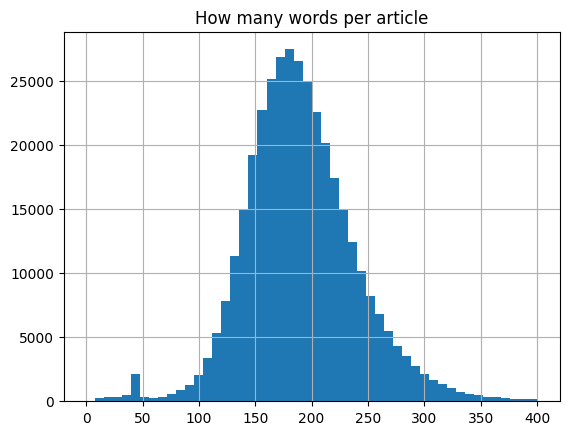

In [10]:
articles_metadata.words_count.hist(bins=50, range=(0,400))
plt.title('How many words per article');

Nous allons consolider les fichiers de clicks en un seul fichier csv

In [6]:
#%%time

if not os.path.exists('clicks.csv'):
    clicks_path = []
    clicks_dir = "/content/oglobotv/clicks/clicks"

    clicks_path = clicks_path + sorted(
            [
                os.path.join(clicks_dir, fname)
                for fname in os.listdir(clicks_dir)
                if fname.endswith(".csv")
            ]
        )
    print("Number of clicks csv:", len(clicks_path))

    _li = []

    for filename in clicks_path:
        df = pd.read_csv(filename, index_col=None, header=0)
        _li.append(df)

    clicks = pd.concat(_li, axis=0, ignore_index=True)
    clicks.to_csv('clicks.csv')
else:
    clicks= pd.read_csv('clicks.csv')

clicks

Number of clicks csv: 385


,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type
0,0,1506825423271737,1506825423000,2,157541,1506826828020,4,3,20,1,20,2
1,0,1506825423271737,1506825423000,2,68866,1506826858020,4,3,20,1,20,2
2,1,1506825426267738,1506825426000,2,235840,1506827017951,4,1,17,1,16,2
3,1,1506825426267738,1506825426000,2,96663,1506827047951,4,1,17,1,16,2
4,2,1506825435299739,1506825435000,2,119592,1506827090575,4,1,17,1,24,2
...,...,...,...,...,...,...,...,...,...,...,...,...
2988176,10051,1508211372158328,1508211372000,2,84911,1508211557302,4,3,2,1,25,1
2988177,322896,1508211376302329,1508211376000,2,30760,1508211672520,4,1,17,1,25,2
2988178,322896,1508211376302329,1508211376000,2,157507,1508211702520,4,1,17,1,25,2
2988179,123718,1508211379189330,1508211379000,2,234481,1508211513583,4,3,2,1,25,2


In [11]:
clicks.isnull().sum()

user_id                0
session_id             0
session_start          0
session_size           0
click_article_id       0
click_timestamp        0
click_environment      0
click_deviceGroup      0
click_os               0
click_country          0
click_region           0
click_referrer_type    0
dtype: int64

### Pour chaque user on va construire la liste des articles cliqués

In [13]:
df = clicks.groupby('user_id').agg(
    LIST_click_article_id = ('click_article_id', lambda x: list(x)),
)
df

,LIST_click_article_id
user_id,
0,"[157541, 68866, 96755, 313996, 160158, 233470,..."
1,"[235840, 96663, 59758, 160474, 285719, 156723,..."
2,"[119592, 30970, 30760, 209122]"
3,"[236065, 236294, 234686, 233769, 235665, 23513..."
4,"[48915, 44488, 195887, 195084, 63307, 336499, ..."
...,...
322892,"[42567, 39894]"
322893,"[50644, 36162]"
322894,"[36162, 168401]"


In [18]:


if not os.path.exists('/content/df.csv'):
    pbar = progressbar.ProgressBar(widgets=[progressbar.Percentage(), progressbar.Bar()], maxval=len(df)).start()

    df['categories'] = ''

    for index, row in df.iterrows():
        pbar.update(index)
        _list_row = []
        for article in row.LIST_click_article_id:
            _list_row.append(articles_metadata[articles_metadata.article_id == article].category_id.values[0])
        df.loc[index]['categories']=_list_row
    df.to_csv('df.csv')
    pbar.finish()
else:
    df= pd.read_csv('/content/df.csv')

In [19]:
df

,user_id,LIST_click_article_id,categories
0,0,"[157541, 68866, 96755, 313996, 160158, 233470,...","[281, 136, 209, 431, 281, 375, 186, 186]"
1,1,"[235840, 96663, 59758, 160474, 285719, 156723,...","[375, 209, 123, 281, 412, 281, 331, 412, 435, ..."
2,2,"[119592, 30970, 30760, 209122]","[247, 26, 26, 332]"
3,3,"[236065, 236294, 234686, 233769, 235665, 23513...","[375, 375, 375, 375, 375, 375, 281, 375, 375, ..."
4,4,"[48915, 44488, 195887, 195084, 63307, 336499, ...","[92, 81, 317, 317, 132, 437, 399]"
...,...,...,...
322892,322892,"[42567, 39894]","[67, 66]"
322893,322893,"[50644, 36162]","[99, 43]"
322894,322894,"[36162, 168401]","[43, 297]"
322895,322895,"[289197, 63746]","[418, 133]"


## Feature engineering:Construction d'un implicit rating

In [20]:
def inputUserRatings(userId):
    _matrix = pd.DataFrame(columns=['click'])
    _row = df.loc[userId]['categories']
    _row = _row.replace('[', '').replace(']', '').replace(',', '').split()

    for index, val in pd.Series(_row).value_counts().items():
        _matrix.loc[index] = int(val)

    _matrix['click_norm'] = _matrix.apply(lambda x : x / _matrix['click'].max())
    _matrix = _matrix.reset_index()
    _matrix = _matrix.rename(columns={"index": "category_id"})
    _matrix['category_id'] = _matrix['category_id'].astype(int)

    return _matrix

In [21]:
inputUserRatings(120)

,category_id,click,click_norm
0,412,6,1.000000
1,437,6,1.000000
2,209,5,0.833333
3,418,5,0.833333
4,409,5,0.833333
5,375,5,0.833333
6,252,4,0.666667
7,6,3,0.500000
8,26,3,0.500000
9,421,3,0.500000


In [22]:
articles_matrix = articles_metadata.loc[:, ['article_id', 'category_id']]
display(articles_matrix.dtypes)

article_id     int64
category_id    int64
dtype: object

## Content based filtering

In [23]:
def recommend5(userId, articles_matrix):
    _input_user_ratings = inputUserRatings(userId)
    _articles_matrix = articles_matrix

    _weighed_articles_matrix = pd.DataFrame(columns=['article_id', 'category_id', 'weight'])
    _weighed_articles_matrix['article_id'] = _articles_matrix['article_id']
    _weighed_articles_matrix['category_id'] = _articles_matrix['category_id']
    #display(_weighed_articles_matrix.dtypes)

    _weighed_articles_matrix['weight'] = _weighed_articles_matrix['category_id'].apply(lambda x :
                                                                                        0
                                                                                       if(_input_user_ratings.loc[_input_user_ratings['category_id'] == x].empty == True)
                                                                                       else
                                                                                        _input_user_ratings.loc[_input_user_ratings['category_id'] == x].click_norm.values[0]
                                                                                      )


    return _weighed_articles_matrix[_weighed_articles_matrix.weight > 0].sort_values(by=['weight'], ascending=False)

In [32]:
#%%time
res = recommend5(0 , articles_matrix)
res

,article_id,category_id,weight
158832,158832,281,1.0
154313,154313,281,1.0
154323,154323,281,1.0
154322,154322,281,1.0
154321,154321,281,1.0
...,...,...,...
95817,95817,209,0.5
95816,95816,209,0.5
95815,95815,209,0.5
95814,95814,209,0.5


In [33]:
clicks.head()

,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type
0,0,1506825423271737,1506825423000,2,157541,1506826828020,4,3,20,1,20,2
1,0,1506825423271737,1506825423000,2,68866,1506826858020,4,3,20,1,20,2
2,1,1506825426267738,1506825426000,2,235840,1506827017951,4,1,17,1,16,2
3,1,1506825426267738,1506825426000,2,96663,1506827047951,4,1,17,1,16,2
4,2,1506825435299739,1506825435000,2,119592,1506827090575,4,1,17,1,24,2


In [34]:
articles = clicks.click_article_id.value_counts().index

In [36]:
#articles_metadata = articles_metadata.loc[articles].reset_index()
#articles_metadata

## Matrice des similarités

In [37]:
pickle = pd.read_pickle('/content/oglobotv/articles_embeddings.pickle')
pickle = pickle[articles]
pickle.shape

(46033, 250)

In [38]:
#%%time
cosine_similarities  = cosine_similarity(pickle, pickle)

In [39]:
with open('cosine_similarities.npy', 'wb') as f:
    np.save(f, cosine_similarities)

In [31]:
cosine_similarities.shape

(46033, 46033)

In [40]:
def simScores(index):
    sim_scores = list(enumerate(cosine_similarities[index]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:21]

    return sim_scores #warning : based on index !! not article_id

In [41]:
def CBrecommendations(userId):
    """Return the top-N recommendation for an user using content-based filtering.

    Args:
        userId(int): userId of the user we want to recommmend articles to.

    Return:
        a list of articleId we recommend. Sort by confidence descending.
    """

    #Calculate category preferences
        #Create category weight matrix.
    _category_weight_matrix = pd.DataFrame(columns=['click'])

        #Get user favorites categories.
    _row = df.loc[userId]['categories']
    _row = _row.replace('[', '').replace(']', '').replace(',', '').split()

        #Add user favorites categories to category weight matrix.
    for index, val in pd.Series(_row).value_counts().items():
        _category_weight_matrix.loc[index] = int(val)

        #Normalize and format category weight matrix.
    _category_weight_matrix['click_norm'] = _category_weight_matrix.apply(lambda x : x / _category_weight_matrix['click'].max())
    _category_weight_matrix = _category_weight_matrix.reset_index()
    _category_weight_matrix = _category_weight_matrix.rename(columns={"index": "category_id"})
    _category_weight_matrix['category_id'] = _category_weight_matrix['category_id'].astype(int)


    #Calculate article similarities
    _article_similarity_score = []
    for index, row in _category_weight_matrix.iterrows():
        #print(row)
        _x = simScores(int(row.category_id))
        for i in range(1, int(row.click) + 1):
            _article_similarity_score = _article_similarity_score + _x

    #Building dataframe
    _recommendation_df = pd.DataFrame(columns=['index', 'article_id', 'category_id', 'sim_score', 'click_weight'])
    for row in _article_similarity_score:
        _index = row[0]
        _article_id = articles_metadata.loc[_index].article_id
        _category_id = articles_metadata.loc[_index].category_id
        if _category_id in _category_weight_matrix.category_id.values:
            print('RESULT',_category_weight_matrix.loc[_category_weight_matrix.category_id == 281])
            _click_weight = _category_weight_matrix.loc[_category_weight_matrix.category_id == 281].click_norm.values[0] #We use normalized value of clicked, we could use non normalized too.
        else:
            _click_weight = 0
        _sim_score = row[1]
        _new_row = {'index':_index, 'article_id':_article_id, 'category_id':_category_id, 'sim_score':_sim_score, 'click_weight':_click_weight}
        _recommendation_df = _recommendation_df.append(_new_row, ignore_index=True)

    #Calculate final score
    _recommendation_df = _recommendation_df.assign(score = lambda x: x['sim_score'] * x['click_weight'])

    _recommendation_list = np.array(_recommendation_df.sort_values(by=['score'], ascending=False).head(5).article_id.values, dtype='int')

    return _recommendation_list, _recommendation_df

In [42]:
CBrecommendations(322892)

<ipython-input-41-d962b8156e4a>:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  _recommendation_df = _recommendation_df.append(_new_row, ignore_index=True)
<ipython-input-41-d962b8156e4a>:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  _recommendation_df = _recommendation_df.append(_new_row, ignore_index=True)
<ipython-input-41-d962b8156e4a>:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  _recommendation_df = _recommendation_df.append(_new_row, ignore_index=True)
<ipython-input-41-d962b8156e4a>:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  _recommendation_df = _recommendation_df.append(_new_row, ignore_index=True)
<ipython-inp

(array([286726, 205509, 337278, 338017, 337782]),
       index  article_id  category_id  sim_score  click_weight  score
 0   11947.0    286726.0        418.0   0.850974           0.0    0.0
 1   27647.0    205509.0        331.0   0.847459           0.0    0.0
 2     141.0    276946.0        409.0   0.845432           0.0    0.0
 3   35687.0    289948.0        421.0   0.842618           0.0    0.0
 4    2552.0    293096.0        421.0   0.842047           0.0    0.0
 5   17509.0    292631.0        421.0   0.841824           0.0    0.0
 6   15337.0    292551.0        421.0   0.839207           0.0    0.0
 7    1860.0    292424.0        421.0   0.837868           0.0    0.0
 8    1180.0    292543.0        421.0   0.836430           0.0    0.0
 9   14356.0    292409.0        421.0   0.834349           0.0    0.0
 10  16460.0    292570.0        421.0   0.834198           0.0    0.0
 11  24328.0    290542.0        421.0   0.830742           0.0    0.0
 12   5270.0    286735.0        418.0   

# Collaborative filtering avec la librairie surprise

In [47]:
clicks.head()

,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type
0,0,1506825423271737,1506825423000,2,157541,1506826828020,4,3,20,1,20,2
1,0,1506825423271737,1506825423000,2,68866,1506826858020,4,3,20,1,20,2
2,1,1506825426267738,1506825426000,2,235840,1506827017951,4,1,17,1,16,2
3,1,1506825426267738,1506825426000,2,96663,1506827047951,4,1,17,1,16,2
4,2,1506825435299739,1506825435000,2,119592,1506827090575,4,1,17,1,24,2


In [48]:
clicks

,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type
0,0,1506825423271737,1506825423000,2,157541,1506826828020,4,3,20,1,20,2
1,0,1506825423271737,1506825423000,2,68866,1506826858020,4,3,20,1,20,2
2,1,1506825426267738,1506825426000,2,235840,1506827017951,4,1,17,1,16,2
3,1,1506825426267738,1506825426000,2,96663,1506827047951,4,1,17,1,16,2
4,2,1506825435299739,1506825435000,2,119592,1506827090575,4,1,17,1,24,2
...,...,...,...,...,...,...,...,...,...,...,...,...
2988176,10051,1508211372158328,1508211372000,2,84911,1508211557302,4,3,2,1,25,1
2988177,322896,1508211376302329,1508211376000,2,30760,1508211672520,4,1,17,1,25,2
2988178,322896,1508211376302329,1508211376000,2,157507,1508211702520,4,1,17,1,25,2
2988179,123718,1508211379189330,1508211379000,2,234481,1508211513583,4,3,2,1,25,2


In [49]:
#click_sample= pd.read_csv('/content/oglobotv/clicks_sample.csv')
df=pd.read_csv('/content/df.csv',index_col=0)

In [50]:
clicks=pd.read_csv('/content/clicks.csv',index_col=0)

In [51]:
clicks.columns

Index(['user_id', 'session_id', 'session_start', 'session_size',
       'click_article_id', 'click_timestamp', 'click_environment',
       'click_deviceGroup', 'click_os', 'click_country', 'click_region',
       'click_referrer_type'],
      dtype='object')

### On récupère les user_id et les clicks

In [52]:
clicks_df=clicks[['user_id','click_article_id']]

In [53]:
clicks_df

,user_id,click_article_id
0,0,157541
1,0,68866
2,1,235840
3,1,96663
4,2,119592
...,...,...
2988176,10051,84911
2988177,322896,30760
2988178,322896,157507
2988179,123718,234481


## Implicit rating

In [56]:
clicks_df['ratings']=''

<ipython-input-56-ee2bcd00f0fb>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clicks_df['ratings']=''


In [57]:
def rating(user_id,item):

  return round(round(df.loc[user_id]['LIST_click_article_id'].count(str(item))/len(df.loc[user_id]['LIST_click_article_id']),2)*100,2)

In [58]:
rating(2,30970)

3.0

In [59]:
clicks_df

,user_id,click_article_id,ratings
0,0,157541,
1,0,68866,
2,1,235840,
3,1,96663,
4,2,119592,
...,...,...,...
2988176,10051,84911,
2988177,322896,30760,
2988178,322896,157507,
2988179,123718,234481,


In [60]:
data=pd.DataFrame(columns=['user_id','click_article_id','ratings'])

### on va remplir la colonne 'rating' de la matrice 'clicks_df' à l'aide des ratings implicits construits

In [61]:
data=pd.DataFrame
for index, row in clicks_df.iterrows():

  row['ratings']= rating(row['user_id'],row['click_article_id'])
  clicks_df.iloc[index]=row


In [62]:
clicks_df.head()

,user_id,click_article_id,ratings
0,0,157541,2.0
1,0,68866,2.0
2,1,235840,1.0
3,1,96663,1.0
4,2,119592,3.0


In [63]:
_list=list(clicks_df['ratings'].unique())

In [64]:
_list

[2.0, 1.0, 3.0, 0.0, 6.0, 4.0, 7.0, 5.0, 8.0, 10.0, 9.0]

In [65]:
clicks_df.to_csv('clicks_df.csv')

In [66]:
clicks_df=pd.read_csv('clicks_df.csv',index_col=0)

In [67]:
clicks_df.head()

,user_id,click_article_id,ratings
0,0,157541,2.0
1,0,68866,2.0
2,1,235840,1.0
3,1,96663,1.0
4,2,119592,3.0


## Implémentation de surprise

In [71]:
reader = Reader(rating_scale=(0.0, 10))

In [72]:
data = Dataset.load_from_df(clicks_df, reader)

In [73]:
trainset, testset = train_test_split(data, test_size=0.25)

In [74]:
from collections import defaultdict

from surprise import Dataset, SVD

def get_top_n(predictions, n=5):
    """Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    """

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

## Choix de l'algorithme

In [75]:
algo = SVD()
algo.fit(trainset)

# Than predict ratings for all pairs (u, i) that are NOT in the training set.
#testset = trainset.build_anti_testset()
predictions = algo.test(testset)

top_n = get_top_n(predictions, n=5)

In [76]:

algo_BaselineOnly = BaselineOnly()
algo_BaselineOnly.fit(trainset)
predictions_BaselineOnly=algo_BaselineOnly.test(testset)

Estimating biases using als...


In [77]:

algo_NormalPredictor = NormalPredictor()
algo_NormalPredictor.fit(trainset)
predictions_NormalPredictor=algo_NormalPredictor.test(testset)

In [78]:
accuracy.rmse(predictions_NormalPredictor)

RMSE: 2.2050


2.20499276695871

In [79]:
accuracy.rmse(predictions_BaselineOnly)

RMSE: 1.2807


1.280733039874609

In [80]:
accuracy.rmse(predictions)

RMSE: 1.0557


1.055718060696429

In [81]:
import pickle

pickle.dump(algo,open('algo.pkl','wb'))

## Test

In [82]:
pickle.dump(predictions,open('predictions.pkl','wb'))
pickle.dump(top_n,open('top_n.pkl','wb'))

In [83]:
import surprise
surprise.dump.dump('algo_svd.pkl', predictions=predictions, algo=algo, verbose=0)

In [84]:
pred,alg=surprise.dump.load('algo_svd.pkl')

In [85]:
pred

[Prediction(uid=114113, iid=272143, r_ui=6.0, est=6.005134739192004, details={'was_impossible': False}),
 Prediction(uid=90292, iid=218369, r_ui=0.0, est=0.5873505643681887, details={'was_impossible': False}),
 Prediction(uid=97311, iid=336223, r_ui=1.0, est=2.7579516687101826, details={'was_impossible': False}),
 Prediction(uid=164308, iid=59057, r_ui=1.0, est=1.9736450239968057, details={'was_impossible': False}),
 Prediction(uid=107842, iid=166581, r_ui=1.0, est=2.0473904500764566, details={'was_impossible': False}),
 Prediction(uid=39132, iid=36162, r_ui=1.0, est=1.2442145953367496, details={'was_impossible': False}),
 Prediction(uid=228394, iid=133287, r_ui=1.0, est=0.9257524744678018, details={'was_impossible': False}),
 Prediction(uid=21765, iid=161585, r_ui=4.0, est=3.6648791537009666, details={'was_impossible': False}),
 Prediction(uid=8939, iid=284410, r_ui=0.0, est=0.2023045134565964, details={'was_impossible': False}),
 Prediction(uid=63957, iid=214631, r_ui=0.0, est=0.1839

In [86]:
top_n[65694]

[(114054, 0.2747666185594432),
 (161077, 0.17224737363748444),
 (61382, 0.17049089190693695),
 (206775, 0.1465763543922565),
 (235323, 0.13728978001301428)]

In [87]:
top_n

defaultdict(list,
            {114113: [(272143, 6.005134739192004)],
             90292: [(272143, 1.5194890419557563),
              (124177, 1.448478427679439),
              (156560, 1.4171135638826802),
              (235870, 1.2321904288229675),
              (119193, 1.2250024472788137)],
             97311: [(96210, 2.968842905927957),
              (158536, 2.957060365423553),
              (160417, 2.8765362203513782),
              (336223, 2.7579516687101826),
              (277491, 2.4916149295604875)],
             164308: [(336223, 2.341799870820185),
              (59057, 1.9736450239968057)],
             107842: [(158536, 2.4135661846187926),
              (166581, 2.0473904500764566),
              (156625, 1.7131878926422068)],
             39132: [(285343, 1.4400562901175764),
              (36162, 1.2442145953367496),
              (285095, 0.9516998292657313)],
             228394: [(338339, 1.8827069016573674),
              (182776, 1.1740190912905466),
       